# Linear Discriminant Analysis (LDA)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

## Exercise 1: Train LDA 

$S_k = \frac{1}{N_k-1}\Sigma_{n \in C_k}(X_n-m_k)(X_n-m_k)^T$

$S_W = \frac{1}{2}(S_1 + S_2)$

$S_B = (m_2-m_1)(m_2-m_1)^T$

LDA의 weights와 bias를 훈련시키는 방정식:

$$w = S_W^{-1}(m_2-m_1)$$

$$b = -\frac{1}{2}W^T(m_1+m_2)$$

데이터 $X$에 대해 weights와 bias를 계산하는 함수 `train_lda(X, y)` (단, 이진 분류 문제라고 가정):

In [15]:
def train_lda(X, y):
    """
    X := data with (N samples x D features) dimensionality 
    y := labels, a vector of N samples containing integer class labels
    """
    class_1, class_2 = X[y == 1], X[y == 2]
    m_1 = class_1.mean(axis=0)
    m_2 = class_2.mean(axis=0)
    
    S_w = 0.5 * (np.cov(np.transpose(class_1)) + np.cov(np.transpose(class_2)))
    w = np.dot(np.linalg.inv(S_w), (m_2 - m_1))
    b = np.dot(-0.5 * np.transpose(w), (m_1 + m_2))
    
    return w, b

## Exercise 2: Apply LDA

weights와 bias를 사용하여 LDA를 새로운 데이터에 적용하는 방정식:


$$f(x) = w^T x + b$$

데이터 $X$에 대해 weights와 bias를 이용해 레이블을 예측하고 이에 따라 데이터를 분류하는 함수 `apply_lda(X, weights, bias)` 작성:

In [19]:
def apply_lda(X, weights, bias):
    y = np.array([])
    N_samples = X.shape[0]
    
    for i in range(N_samples):
        x = X[i, :]
        f_x = np.dot(np.transpose(weights), x) + bias
        pred = 1 if f_x <= 0 else 2
        y = np.append(y, pred)
    
    return y

## Exercise 3: Classify the Iris dataset

위에서 구현한 코드를 테스트하기 위하여:
- **pandas** 라이브러리에서 제공하는 `dataset.load_iris()` Iris 데이터 사용
- **seaborn** 을 활용하여 내장함수 `pairplot()`을 이용해 features를 시각화

1)  LDA를 훈련 및 적용하고, 분류 정확도 계산:

Number of features:  4
Number of train examples:  80
Number of valid examples:  20


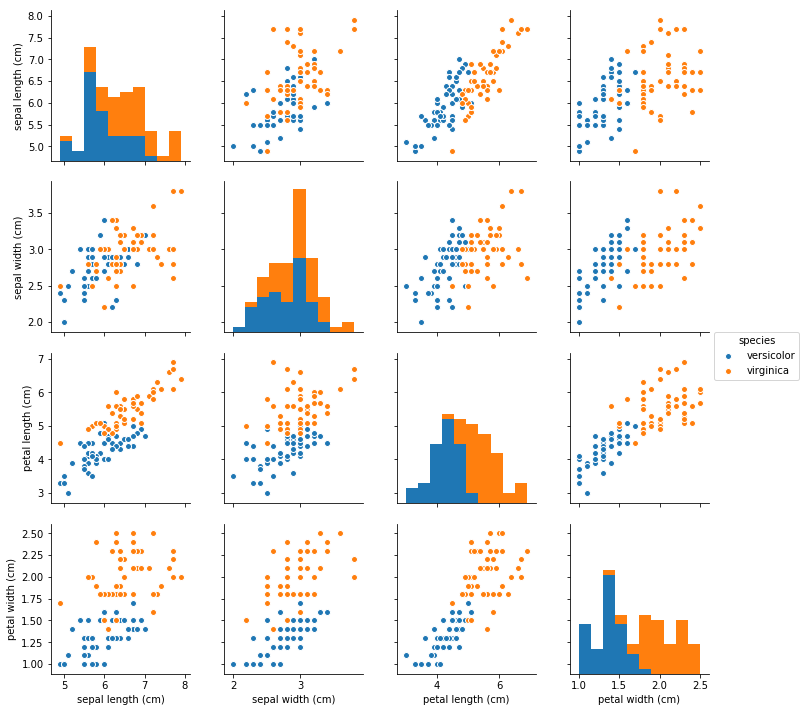

In [17]:
# Load Iris dataset and select 2 classes
iris = datasets.load_iris()
labels = [1, 2]
idx = np.logical_or(iris.target == labels[0], iris.target == labels[1])
iris.data = iris.data[idx, :]
iris.target = iris.target[idx]

# Make a pandas dataframe
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["species"] = iris.target_names[iris.target]

# Plot data
sns.pairplot(df, hue="species")

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)
print("Number of features: ", X_train.shape[1])
print("Number of train examples: ", X_train.shape[0])
print("Number of valid examples: ", X_valid.shape[0])


2)  **sklearn**의 `LDA()`를 사용하여 데이터를 분석하고 그 결과를 직접 구현한 LDA와 비교:

In [26]:
weights, bias = train_lda(X_train, y_train)
y_pred = apply_lda(X_valid, weights, bias)
lda_accuracy = metrics.accuracy_score(y_valid, y_pred)
print("My LDA:", lda_accuracy * 100)

clf = LDA()
clf.fit(X_train, y_train)
sklearn_y_pred = clf.predict(X_valid)
sklearn_lda_accuracy = metrics.accuracy_score(y_valid, sklearn_y_pred)
print("Sklearn LDA:", sklearn_lda_accuracy * 100)

My LDA: 80.0
Sklearn LDA: 80.0


위에서 구현한 LDA 함수를 sklearn에서 제공하는 `LDA()` 와 비교한 결과, 동일한 정확도를 보임을 확인하였습니다.

## Exercise 4: Preprocess features

때때로 일부 features는 LDA가 만든 **linear separability**에 대한 가정을 위반합니다. 이 경우, 각 feature에 주어진 함수를 적용하여 전처리할 수 있으며, 이는 일반화된 LDA를 생성합니다.
$$ y = \sum_i^D w_i f_i(\mathbf{x}_i) $$ 

Un-processed data 분류:

Accuracy validation: 65.00%


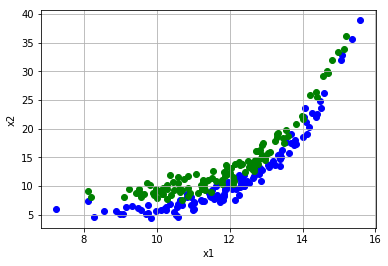

In [27]:
ds_data = 'data/non-lin_train.data'
ds_labels ='data/non-lin_train.labels'
X = np.loadtxt(ds_data)
y = np.loadtxt(ds_labels)
n_samples = y.size

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure()
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1] ,color='b')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='g')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

# Classify un-processed data
clf = LDA()
clf.fit(X_train, y_train)
score = clf.score(X_valid, y_valid) * 100
print('Accuracy validation: {:.2f}%'.format(score))


히스토그램을 살펴보면, 위 데이터는 모든 클래스가 가우시안 분포를 갖는다는 가정 A1을 위반함을 알 수 있습니다. Un-processed data의 plot은 지수함수와 비슷한 형태를 나타냅니다. 따라서 성능을 향상시키기 위해 로그함수를 이용하여 feature를 전처리하는 작업을 수행하였습니다.

Processed data 분류:

Accuracy validation: 75.00%


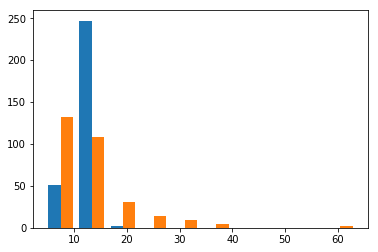

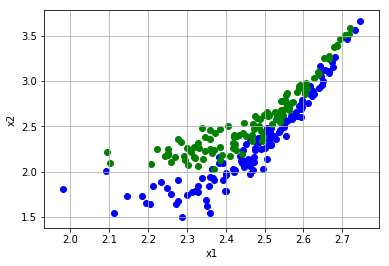

In [36]:
plt.hist(X)
processed_data = np.log(X)

X_train, X_valid, y_train, y_valid = train_test_split(processed_data, y, test_size=0.2, random_state=42)

plt.figure()
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1] ,color='b')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='g')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

clf = LDA()
clf.fit(X_train, y_train)
score = clf.score(X_valid, y_valid) * 100
print("Accuracy validation: {:.2f}%".format(score))

전처리로써 로그함수를 사용한 결과, 두 클래스의 분포가 좀 더 선형에 가까우며 두 클래스 간의 거리가 더 멀어졌음을 확인할 수 있습니다. 분류 정확도 또한 전보다 10% 상승한 75.00%를 나타냅니다.

## Exercise 5: Extract features

Un-processed data 분류:

Accuracy validation: 26.67%


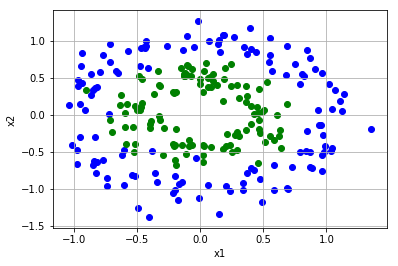

In [37]:
ds_data = 'data/circles_train.data'
ds_labels ='data/circles_train.labels'
X = np.loadtxt(ds_data)
y = np.loadtxt(ds_labels)
n_samples = len(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure()
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1] ,color='b')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='g')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

# Classify un-processed data
clf = LDA()
clf.fit(X_train, y_train)
score = clf.score(X_valid, y_valid) * 100
print('Accuracy validation: {:.2f}%'.format(score))

위 데이터세트에서 클래스들간의 공분산 행렬이 서로 다르므로, 이는 가정 A2에 위배됨을 알 수 있습니다. 이에 따라 두 개의 클래스를 원활하게 분리하기 위해 다른 차원을 추가하여 문제를 해결하고자 합니다. 유클리드 거리법을 사용하여 각 데이터 포인트에 대해 원점까지의 거리를 나타내는 새로운 feature를 추가하였습니다.

추가적인 features를 가진 data 분류:

Accuracy validation: 95.00%


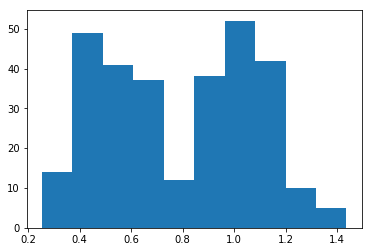

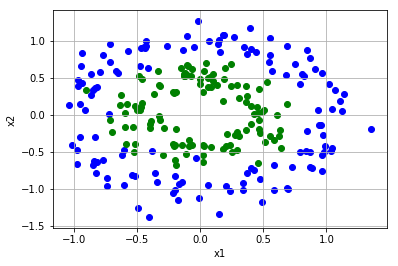

In [40]:
N_samples = X.shape[0]
processed_data = np.array([])
processed_data = np.vstack([(x1, x2, np.sqrt(x1*x1 + x2*x2)) for x1, x2 in X])
plt.hist(processed_data[:, 2])

X_train, X_valid, y_train, y_valid = train_test_split(processed_data, y, test_size=0.2, random_state=42)

plt.figure()
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1] ,color='b')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='g')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

# Classify processed data with additional features
clf = LDA()
clf.fit(X_train, y_train)
score = clf.score(X_valid, y_valid) * 100
print('Accuracy validation: {:.2f}%'.format(score))

추가적인 features를 사용한 결과, 95%까지 분류 정확도가 상승했음을 확인하였습니다.

## Exercise 6: Other LDA-like algorithms

Accuracy validation: 88.33%


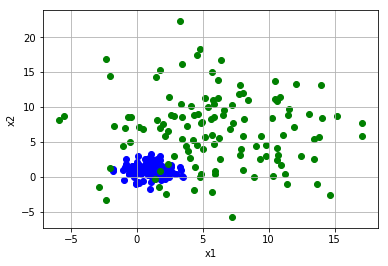

In [42]:
ds_data = 'data/unbalanced_train.data'
ds_labels ='data/unbalanced_train.labels'
X = np.loadtxt(ds_data)
y = np.loadtxt(ds_labels)
n_samples = len(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure()
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1] ,color='b')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='g')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

# Classify un-processed data
clf = LDA()
clf.fit(X_train, y_train)
score = clf.score(X_valid, y_valid) * 100
print('Accuracy validation: {:.2f}%'.format(score))


위 데이터에서 두 클래스의 공분산이 다르므로 이는 가정 A2에 위배됨을 알 수 있습니다. 또한 두 클래스의 분포가 서로 겹쳐있으므로 최적의 결정 경계를 찾는 작업이 중요합니다. 두 그래프는 linearly separable 하지 않기 때문에, 결정 경계는 2차 이상의 함수가 될 것 입니다. 이를 찾기 위해 `QDA()`를 사용하여 작업을 진행하였습니다.

In [43]:
qda = QDA()
qda.fit(X_train, y_train)
score = qda.score(X_valid, y_valid) * 100
print('Accuracy validation: {:.2f}%'.format(score))

Accuracy validation: 95.00%


`QDA()` 를 사용하여 새롭게 예측한 데이터는 95%의 정확도로 분리되었습니다.